11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training GAN...
GAN Epoch 1/5 completed
GAN Epoch 2/5 completed
GAN Epoch 3/5 completed
GAN Epoch 4/5 completed
GAN Epoch 5/5 completed

Training Classifier...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.8834 - loss: 0.4019 - val_accuracy: 0.9832 - val_loss: 0.0535
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 113ms/step - accuracy: 0.9829 - loss: 0.0543 - val_accuracy: 0.9868 - val_loss: 0.0430
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/step - accuracy: 0.9891 - loss: 0.0349 - val_accuracy: 0.9874 - val_loss: 0.0371
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 112ms/step - accuracy: 0.9931 - loss: 0.0229 - val_accuracy: 0.9892 - val_loss: 0.0347
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 115ms/step - accuracy: 0.9947 - loss: 0.0171 - val_accuracy: 0.9890 - val_loss: 0.0328
313/313 - 3s - 8ms/step - accuracy: 0.9890 - loss: 0.0328

Test accuracy: 0.9890000224113464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


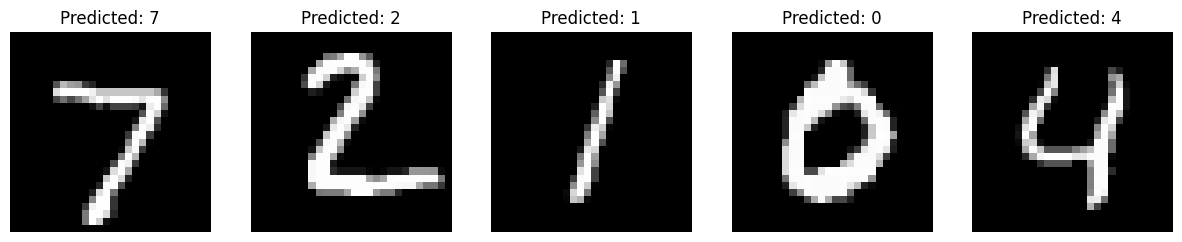

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Optimize dataset pipeline
BUFFER_SIZE = 60000
BATCH_SIZE = 128  # Reduced batch size for faster training
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)  # Added prefetch for better performance

def make_generator_model():
    model = models.Sequential([
        # Simplified generator architecture
        layers.Dense(7*7*128, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = models.Sequential([
        # Simplified discriminator architecture
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Simplified classifier
classifier = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # Added input layer explicitly
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the classifier
classifier.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                   cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
EPOCHS = 5  # Reduced epochs

# Train GAN
print("Training GAN...")
for epoch in range(EPOCHS):
    for image_batch, _ in train_dataset:
        train_step(image_batch)
    print(f'GAN Epoch {epoch + 1}/{EPOCHS} completed')

# Train classifier separately
print("\nTraining Classifier...")
classifier.fit(train_images, train_labels,
              epochs=5,  # Reduced epochs
              batch_size=128,
              validation_data=(test_images, test_labels),
              verbose=1)

# Evaluate the model
test_loss, test_acc = classifier.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Visualize some predictions
predictions = classifier.predict(test_images[:5])
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axs):
    ax.imshow(test_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Predicted: {np.argmax(predictions[i])}')
    ax.axis('off')
plt.show()

Training VAE...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - loss: 1.2888e-05 - val_loss: 0.0000e+00
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 3.5295e-12 - val_loss: 0.0000e+00
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00

Training Classifier...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1100 - loss: 2.3020 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1124 - loss: 2.3014 - val_accuracy: 0.1135 - val_loss: 2.3012
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1130 - loss: 2.3010 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1137 - loss: 2.3011 - val_accuracy: 0.1135 - val_loss: 2.3011
Epo

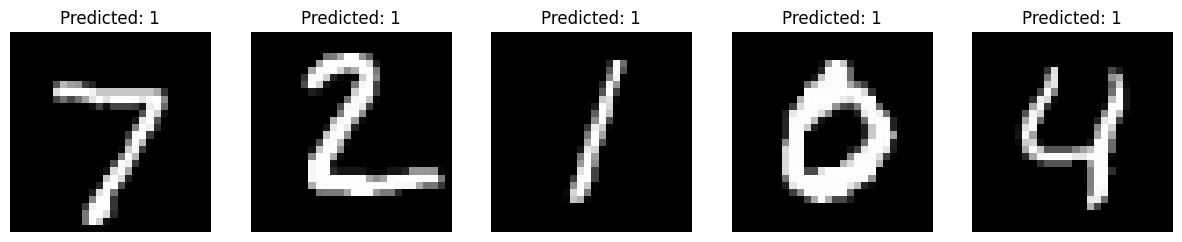

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


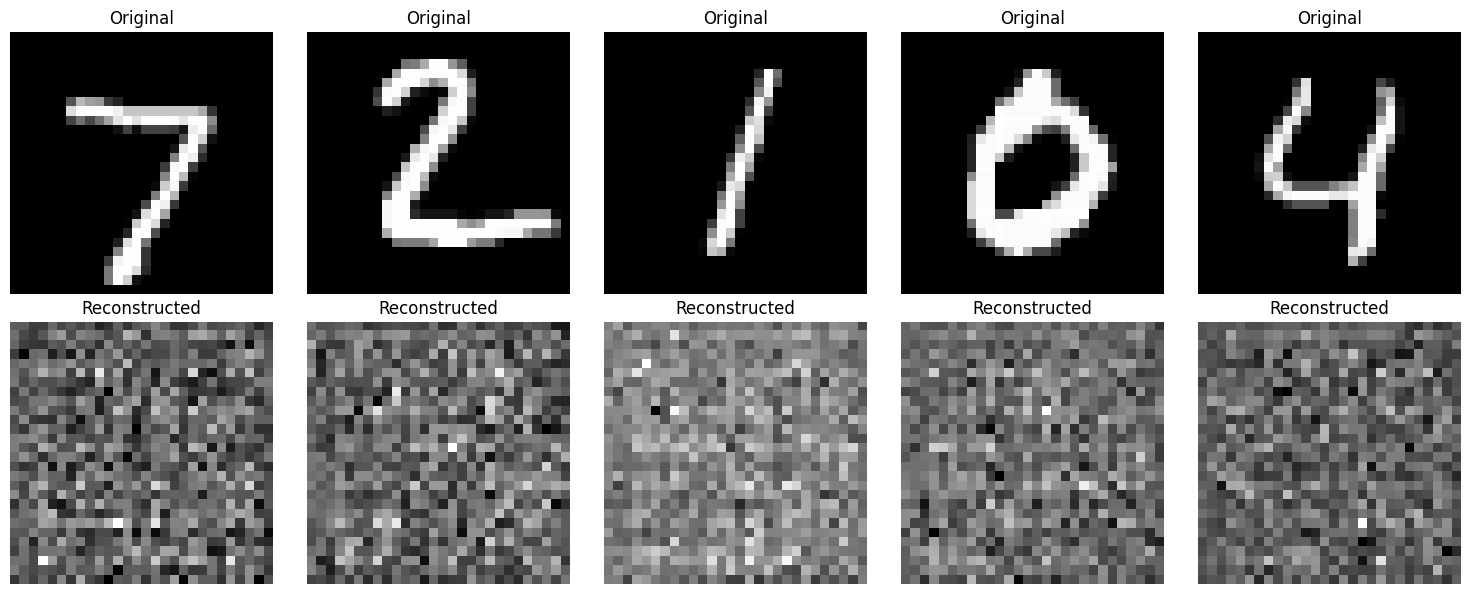

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape data
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

# Network parameters
latent_dim = 16

# Custom sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Custom VAE model
class VAE(models.Model):
    def __init__(self, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_inputs = layers.Input(shape=(28, 28, 1))
        self.x1 = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')
        self.x2 = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(32, activation='relu')

        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

        # Decoder
        self.decoder_dense = layers.Dense(7 * 7 * 64, activation='relu')
        self.decoder_reshape = layers.Reshape((7, 7, 64))
        self.decoder_conv1 = layers.Conv2DTranspose(64, 3, activation='relu',
                                                  strides=2, padding='same')
        self.decoder_conv2 = layers.Conv2DTranspose(32, 3, activation='relu',
                                                  strides=2, padding='same')
        self.decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid',
                                                    padding='same')

    def encode(self, x):
        x = self.x1(x)
        x = self.x2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z

    def decode(self, z):
        x = self.decoder_dense(z)
        x = self.decoder_reshape(x)
        x = self.decoder_conv1(x)
        x = self.decoder_conv2(x)
        return self.decoder_outputs(x)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encode(inputs)
        reconstructed = self.decode(z)
        # Add KL divergence regularization loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        self.add_loss(kl_loss)
        return reconstructed

# Create VAE model
vae = VAE(latent_dim)

# Compile VAE
vae.compile(optimizer='adam')

# Define and compile classifier
classifier = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(latent_dim,)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

classifier.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train VAE
print("Training VAE...")
vae.fit(x_train, x_train,
        epochs=5,
        batch_size=128,
        validation_data=(x_test, x_test))

# Function to get encodings
def get_encodings(model, data):
    return model.encode(data)[0]  # Get z_mean

# Get latent space representations
train_encoded = get_encodings(vae, x_train)
test_encoded = get_encodings(vae, x_test)

# Train classifier
print("\nTraining Classifier...")
classifier.fit(train_encoded, y_train,
              epochs=5,
              batch_size=128,
              validation_data=(test_encoded, y_test))

# Evaluate
test_loss, test_acc = classifier.evaluate(test_encoded, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Visualize predictions
predictions = classifier.predict(test_encoded[:5])
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axs):
    ax.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Predicted: {np.argmax(predictions[i])}')
    ax.axis('off')
plt.show()

# Visualize reconstructions
n = 5
original_images = x_test[:n]
reconstructed_images = vae.predict(original_images)

fig, axs = plt.subplots(2, n, figsize=(15, 6))
for i in range(n):
    # Original images
    axs[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title('Original')

    # Reconstructed images
    axs[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title('Reconstructed')

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
print("Loading MNIST dataset...")
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Optimize dataset pipeline
BUFFER_SIZE = 60000
BATCH_SIZE = 256
TIME_EMBEDDING_DIM = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

# Diffusion hyperparameters
timesteps = 20
beta_start = 0.0001
beta_end = 0.02
betas = tf.linspace(beta_start, beta_end, timesteps)
alphas = 1.0 - betas
alphas_cumprod = tf.math.cumprod(alphas)
alphas_cumprod_prev = tf.pad(alphas_cumprod[:-1], [[1, 0]], constant_values=1.0)
sqrt_recip_alphas = tf.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = tf.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = tf.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

class TimeEmbedding(layers.Layer):
    def __init__(self, embedding_dim=TIME_EMBEDDING_DIM, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.half_dim = embedding_dim // 2

    def call(self, timesteps):
        emb = tf.math.log(10000.0) / (self.half_dim - 1)
        emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -emb)
        emb = tf.cast(timesteps, dtype=tf.float32)[:, None] * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
        return emb

class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()

        # Time embedding
        self.time_embed = TimeEmbedding(TIME_EMBEDDING_DIM)
        self.time_proj = layers.Dense(32, activation='swish')
        self.time_proj2 = layers.Dense(32, activation='swish')

        # Downsampling
        self.conv1 = layers.Conv2D(32, 3, padding='same')
        self.norm1 = layers.GroupNormalization()
        self.act1 = layers.Activation('swish')

        self.conv2 = layers.Conv2D(64, 3, strides=2, padding='same')
        self.norm2 = layers.GroupNormalization()
        self.act2 = layers.Activation('swish')

        self.conv3 = layers.Conv2D(64, 3, strides=2, padding='same')
        self.norm3 = layers.GroupNormalization()
        self.act3 = layers.Activation('swish')

        # Middle
        self.conv_mid = layers.Conv2D(64, 3, padding='same')
        self.norm_mid = layers.GroupNormalization()
        self.act_mid = layers.Activation('swish')

        # Upsampling
        self.up1 = layers.UpSampling2D(2)
        self.conv4 = layers.Conv2D(64, 3, padding='same')
        self.norm4 = layers.GroupNormalization()
        self.act4 = layers.Activation('swish')

        self.up2 = layers.UpSampling2D(2)
        self.conv5 = layers.Conv2D(32, 3, padding='same')
        self.norm5 = layers.GroupNormalization()
        self.act5 = layers.Activation('swish')

        # Output
        self.conv_out = layers.Conv2D(1, 3, padding='same')

    def call(self, inputs):
        x, t = inputs

        # Time embedding
        t = self.time_embed(t)
        t = self.time_proj(t)
        t = self.time_proj2(t)

        # Initial conv
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act1(h)

        # Add time embedding
        t_emb = tf.expand_dims(tf.expand_dims(t, 1), 1)
        h = h + t_emb

        # Downsample
        skip1 = h
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act2(h)

        skip2 = h
        h = self.conv3(h)
        h = self.norm3(h)
        h = self.act3(h)

        # Middle
        h = self.conv_mid(h)
        h = self.norm_mid(h)
        h = self.act_mid(h)

        # Upsample
        h = self.up1(h)
        h = layers.concatenate([h, skip2], axis=-1)
        h = self.conv4(h)
        h = self.norm4(h)
        h = self.act4(h)

        h = self.up2(h)
        h = layers.concatenate([h, skip1], axis=-1)
        h = self.conv5(h)
        h = self.norm5(h)
        h = self.act5(h)

        # Output
        return self.conv_out(h)

# Create model
print("Creating model...")
model = DiffusionModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def diffusion_step(batch):
    t = tf.random.uniform(
        shape=(tf.shape(batch)[0],),
        minval=0,
        maxval=timesteps,
        dtype=tf.int32
    )

    noise = tf.random.normal(tf.shape(batch))
    sqrt_alpha_cumprod_t = tf.gather(sqrt_alphas_cumprod, t)
    sqrt_one_minus_alpha_cumprod_t = tf.gather(sqrt_one_minus_alphas_cumprod, t)

    sqrt_alpha_cumprod_t = sqrt_alpha_cumprod_t[:, None, None, None]
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alpha_cumprod_t[:, None, None, None]

    noisy_images = sqrt_alpha_cumprod_t * batch + sqrt_one_minus_alpha_cumprod_t * noise

    with tf.GradientTape() as tape:
        predicted_noise = model([noisy_images, t], training=True)
        loss = tf.reduce_mean(tf.square(noise - predicted_noise))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

# Training loop
print("Starting training...")
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    num_batches = 0

    for batch in train_dataset:
        loss = diffusion_step(batch)
        total_loss += loss
        num_batches += 1

        if num_batches % 10 == 0:
            print(f'Epoch {epoch + 1}/{EPOCHS}, Batch {num_batches}, Loss: {loss:.4f}')

    avg_loss = total_loss / num_batches
    print(f'Epoch {epoch + 1}/{EPOCHS}, Average Loss: {avg_loss:.4f}')

def generate_images(num_images=1):
    x = tf.random.normal((num_images, 28, 28, 1))

    for t in tf.range(timesteps - 1, -1, -1):
        t_batch = tf.fill([num_images], t)
        predicted_noise = model([x, t_batch], training=False)

        alpha_t = tf.gather(alphas, t)
        alpha_t_cumprod = tf.gather(alphas_cumprod, t)
        beta_t = tf.gather(betas, t)

        if t > 0:
            noise = tf.random.normal(tf.shape(x))
        else:
            noise = tf.zeros_like(x)

        x = (1 / tf.sqrt(alpha_t)) * (x - ((beta_t) / tf.sqrt(1 - alpha_t_cumprod)) * predicted_noise) + \
            tf.sqrt(beta_t) * noise

    return x

# Generate samples
print("\nGenerating samples...")
samples = generate_images(5)

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(samples[i].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

Loading MNIST dataset...
Creating model...
Starting training...
Epoch 1/30, Batch 10, Loss: 0.9921
Epoch 1/30, Batch 20, Loss: 0.7561
Epoch 1/30, Batch 30, Loss: 0.6007
Epoch 1/30, Batch 40, Loss: 0.5137
Epoch 1/30, Batch 50, Loss: 0.4796
Epoch 1/30, Batch 60, Loss: 0.3939
Epoch 1/30, Batch 70, Loss: 0.3704
Epoch 1/30, Batch 80, Loss: 0.3682
Epoch 1/30, Batch 90, Loss: 0.3517
Epoch 1/30, Batch 100, Loss: 0.3384
Epoch 1/30, Batch 110, Loss: 0.3241
Epoch 1/30, Batch 120, Loss: 0.3125
Epoch 1/30, Batch 130, Loss: 0.3340
Epoch 1/30, Batch 140, Loss: 0.3191
Epoch 1/30, Batch 150, Loss: 0.2761
Epoch 1/30, Batch 160, Loss: 0.2940
Epoch 1/30, Batch 170, Loss: 0.2866
Epoch 1/30, Batch 180, Loss: 0.2876
Epoch 1/30, Batch 190, Loss: 0.2810
Epoch 1/30, Batch 200, Loss: 0.2809
Epoch 1/30, Batch 210, Loss: 0.2864
Epoch 1/30, Batch 220, Loss: 0.2865
Epoch 1/30, Batch 230, Loss: 0.2447
Epoch 1/30, Average Loss: 0.4092
Epoch 2/30, Batch 10, Loss: 0.2533
Epoch 2/30, Batch 20, Loss: 0.2530
Epoch 2/30, Ba